In [1]:
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
import networkx as nx
import pycombo

## I. Running `pycombo` on a simple Graph

Unweighted non-directed graph

In [3]:
G = nx.karate_club_graph()

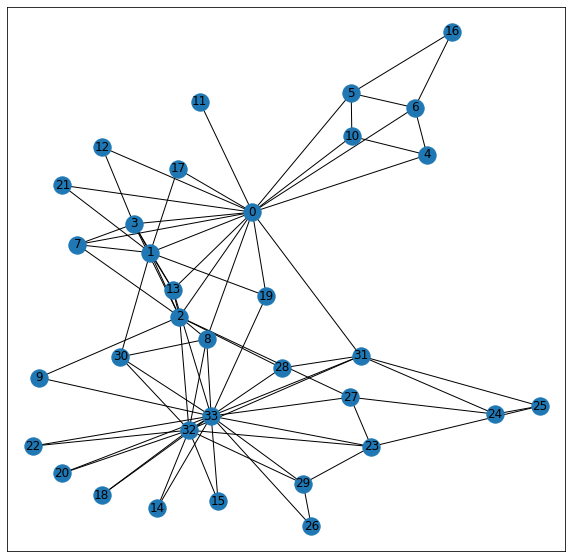

In [4]:
fig, ax =  plt.subplots(figsize=(10,10))

pos=nx.spring_layout(G, seed=42)
nx.draw_networkx(G,pos, ax=ax)

In [5]:
partition, modularity = pycombo.execute(G, return_modularity=True, random_seed=42)

In [6]:
print(f'Partition modularity: {modularity:.5f}')

Partition modularity: 0.41979


## Visualize

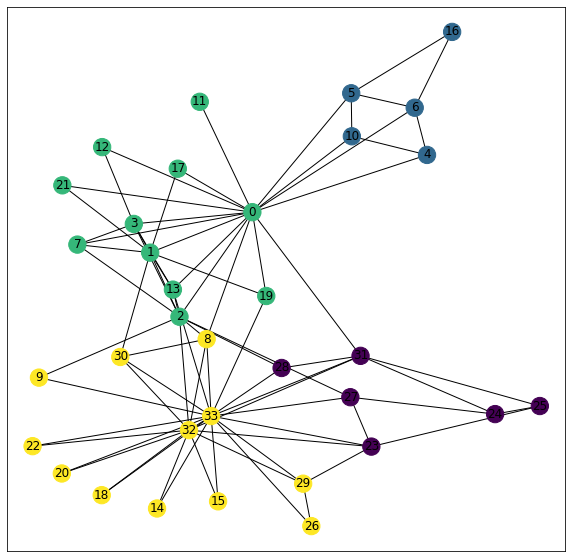

In [7]:
fig, ax =  plt.subplots(figsize=(10,10))

nx.draw_networkx(G, pos, ax=ax, node_color=list(partition.values()))

# II. Running `pycombo` on weighted directed Graph

In [8]:
# Adopted example from here:
# https://networkx.org/documentation/latest/auto_examples/graph/plot_football.html
import urllib.request as urllib
import io
import zipfile

url = "http://www-personal.umich.edu/~mejn/netdata/celegansneural.zip"

sock = urllib.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read("celegansneural.txt").decode()  # read info file
gml = zf.read("celegansneural.gml").decode()  # read gml data
# throw away bogus first line with # from mejn files
gml = gml.split("\n")[1:]
# skip duplicated edges that nx cannot parse
gml = gml[:2598] + gml[2604:6422] + gml[6428:6896] + gml[6902:9818] + gml[9824:10142] + \
    gml[10148:11720] + gml[11726:11936] + gml[11942:12782] + gml[12794:13826] + gml[13832:13904] + \
    gml[13910:13916] + gml[13922:14288] + gml[14294:15416] + gml[15422:15560] + gml[15566:]
G = nx.parse_gml(gml, )  # parse gml data

In [9]:
# compute the layout
pos = nx.kamada_kawai_layout(G)

In [10]:
# Adopted from here:
# https://qxf2.com/blog/drawing-weighted-graphs-with-networkx/
def plot_edges_by_weight(G, pos, weight='weight'):
    all_weights = []
    # Iterate through the graph nodes to gather all the weights
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data[weight]) # we'll use this when determining edge thickness
    unique_weights = list(set(all_weights))
    # Plot the edges by weight
    for w in unique_weights:
        weighted_edges = [(node1,node2) for (node1,node2,data) in G.edges(data=True) if data[weight]==w]
        width = w * 150.0 / sum(all_weights)
        nx.draw_networkx_edges(G, pos, edgelist=weighted_edges, width=width)

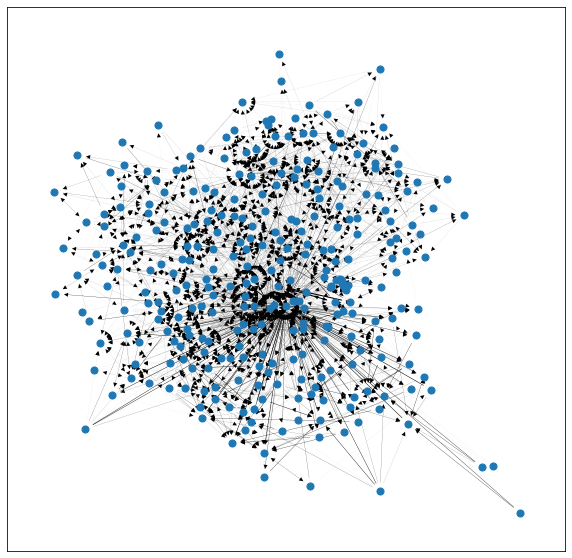

In [11]:
fig, ax =  plt.subplots(figsize=(10,10))

nx.draw_networkx_nodes(G, pos, node_size=50)
plot_edges_by_weight(G, pos, 'value')

In [12]:
partition, modularity = pycombo.execute(G, weight='value', return_modularity=True, random_seed=42)

In [13]:
print(f'Partition modularity: {modularity:.5f}')

Partition modularity: 0.50832


## Visualize

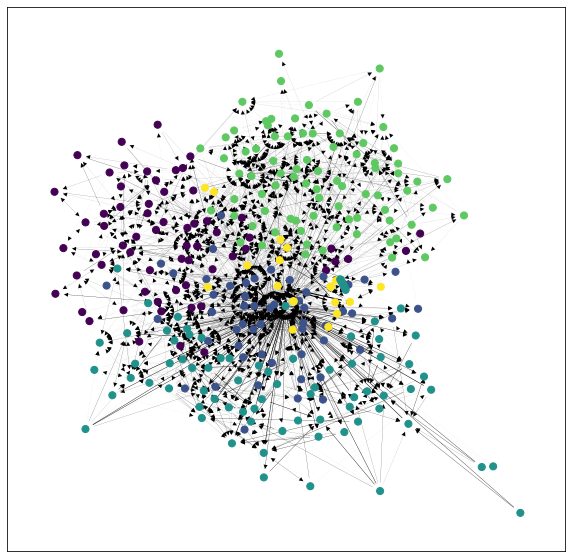

In [14]:
fig, ax =  plt.subplots(figsize=(10,10))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=list(partition.values()))
plot_edges_by_weight(G, pos, 'value')

# III. Execute from file

In [15]:
G = nx.karate_club_graph()

In [16]:
path = './karate.net'
nx.write_pajek(G, path)

In [17]:
partition, modularity = pycombo.execute(path, return_modularity=True, random_seed=42)

In [18]:
print(f'Partition modularity: {modularity:.5f}')

Partition modularity: 0.41979


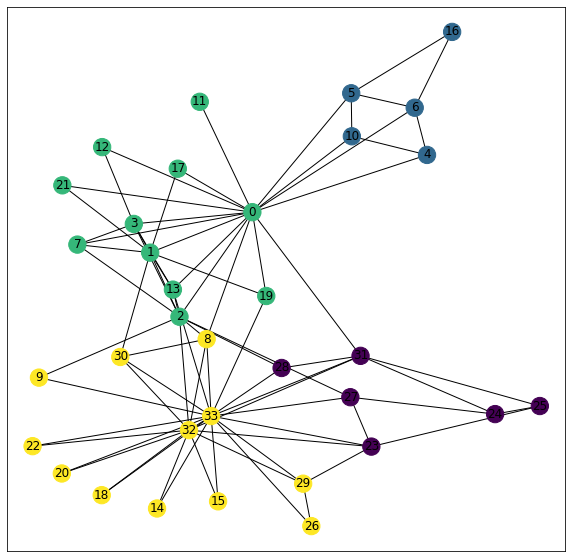

In [19]:
fig, ax =  plt.subplots(figsize=(10,10))
pos=nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos, ax=ax, node_color=list(partition.values()))

Let's remove file now:

In [20]:
! rm karate.net

# IV. Execute from adjacency matrix

`execute` method accepts graph in form of adjecency matrix as list of lists

In [21]:
G = nx.karate_club_graph()

### A. Sparce

In [22]:
sparce_matrix = nx.adjacency_matrix(G)

In [23]:
partition, modularity = pycombo.execute(sparce_matrix.todense().tolist(), return_modularity=True, random_seed=42)
print(f'Partition modularity: {modularity:.5f}')

Partition modularity: 0.41979


### B. Dense

In [24]:
dende_matrix = nx.to_numpy_array(G)

In [25]:
partition, modularity = pycombo.execute(dende_matrix.tolist(), return_modularity=True, random_seed=42)
print(f'Partition modularity: {modularity:.5f}')

Partition modularity: 0.41979


# V. Execute from modularity matrix

User can specify that edge weights already represent modularity scores by setting `treat_as_modularity` option to `True`.

In [26]:
G = nx.karate_club_graph()

In [27]:
def get_modularity_matrix(graph):
    '''
    build modularity matrix and return as numpy array
    '''
    import numpy as np
    A = nx.to_numpy_array(graph)
    if not graph.is_directed():
        A += np.diag(np.diag(A))
    wout = A.sum(axis=1)
    win = A.sum(axis=0)
    T = wout.sum()
    Q = A / T - np.matmul(wout.reshape(-1, 1), win.reshape(1, -1)) / (T ** 2)
    return Q

In [28]:
partition, modularity = pycombo.execute(get_modularity_matrix(G).tolist(), treat_as_modularity=True, random_seed=42)
print(f'Partition modularity: {modularity:.5f}')

Partition modularity: 0.41979
